<a href="https://colab.research.google.com/drive/17r-O-fgF4xqhI5RPNnafFelmT4fFnF2K?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initialization

In [13]:
#@title Select path
#@markdown #Enter here the path of the desired working dir
#@markdown - If executed on colab, give path inside your drive or inside the default environment (uncheck on_drive)
#@markdown - Else give path within your local environment
import os

on_drive = True #@param {type:"boolean"}
path = "DL-2022/JB-runs/" #@param {type:"string"}

try:
  from google.colab import drive
  print("colab detected")
  if on_drive:
    drive.mount('/content/md', force_remount=True)
    os.chdir(os.path.join("/content/md/MyDrive",path))
  else:
    try:
      os.chdir(os.path.join("/content/",path))
    except:
      print("path {} doesn't exist, creating it".format(path))
      os.makedirs(os.path.join("/content/",path))
      print("path created")
except:
  print("working on local environment")
  os.chdir(path)

print("currently in working dir {}".format(os.getcwd()))

colab detected
Mounted at /content/md
currently in working dir /content/md/.shortcut-targets-by-id/14So2tPiPSr8QNh-w-OVpjF99Bm3tFIqp/DL-2022/JB-runs


In [ ]:
#@title Load code
#@markdown #Clone/pull the git repo and install packages
#@markdown ###Do you want to clone the repo?
clone_git = False #@param {type:"boolean"}
#@markdown ###Do you want to pull most recent modification?
pull_git = False #@param {type:"boolean"}
#@markdown ###What is/should be the name of the repo?
repo_name = "project_music_diffusion" #@param {type:"string"}
assert repo_name, "you must provide a name for the repo"
assert not (clone_git and pull_git), "you can't clone and pull at the same time"
try:
  assert clone_git
  print("cloning git repo")
  !git clone --quiet https://gitlab.ethz.ch/jconan/ddpm-music-generation.git $repo_name
  print(f"repository cloned in location {repo_name}")  
except:
  pass

working_dir = os.getcwd()
print("Verifying git repository in current dir")
all_subdirs = [d for d in os.listdir(working_dir) if os.path.isdir(d)]
assert repo_name in all_subdirs, "Please change path {0}, git repository not in current repo".format(working_dir)

# set git identity
!git config --global user.email "jconan@student.ethz.ch"
!git config --global user.name "jconan"

print("Verifying we can access git repo")
try:
    os.chdir(os.path.join(working_dir ,repo_name))
    print("Accessed")
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

if pull_git:
  print("Git pull...")
  # !git stash
  !git pull -q
  print(f"repository pulled and up to date in location {repo_name}")

print("Installing requirements...")
%pip install -q -r requirements.txt
print("Requirements installed!")

os.chdir(working_dir)

Verifying git repository in current dir
Verifying we can access git repo
Accessed
Installing requirements...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.5/270.5 KB 33.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#@title Library import
from project_music_diffusion.mymodels import ETH_Music_Diffusion as MusicGeneratorModel
from project_music_diffusion.mymodels.utils import load_train_dataset

import torch
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage

import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import Audio
import scipy.io.wavfile as wav

from typing import Tuple

import io
from datetime import datetime

from datasets import Dataset, DatasetDict, Features, Image as ds_Image, Value, load_from_disk

import tensorboard
%load_ext tensorboard

#Training

In [ ]:
#@title Load untrained models
os.chdir(os.path.join(working_dir, repo_name,"models"))
print("Loading models...")
untrained_model_ddpm = MusicGeneratorModel(model='virgin-model')
print("DDPM model loaded")
untrained_model_ddim = MusicGeneratorModel(model='virgin-model-ddim')
print("DDIM model loaded")
untrained_model_ddpm_diffloss = MusicGeneratorModel(model=f'virgin-model')
print("2nd DDPM model loaded (for different loss tests)")

Loading models...
DDPM model loaded
DDIM model loaded
2nd DDPM model loaded (for different loss tests)


In [ ]:
#@title train and compare DDPM and DDIM
#@markdown Set name for logging results

#cd into training folder
os.chdir(os.path.join(working_dir, repo_name, "trainings"))

train_dir = "train_DDIM2" #@param {type:"string"}
# train_dir = f"{train_name}_%s"%(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

# create the dir to log training data and ch into it
os.mkdir(train_dir)
os.chdir(train_dir)

#@markdown Path to training dataset
train_ds_path = "/content/md/MyDrive/DL-2022/JB-runs/data/data_0" #@param {type:"string"}

# load the dataset
print("loading dataset")
train_ds = load_train_dataset(train_ds_path)
print(f'dataset loaded, {len(train_ds.dataset)} training data')

for i in range(0,3):
  name1, name2 = f"training_ddpm_epoch_{5*(i+1)}",f"training_ddim_epoch_{5*(i+1)}"
  # print(f"EPOCH {5*i + 1} TO {5*(i+1)} FOR DDPM")
  # untrained_model_ddpm.train(train_ds, name=name1, nb_epochs=5,)  
  print(f"EPOCH {5*i + 1} TO {5*(i+1)} FOR DDIM")
  untrained_model_ddim.train(train_ds, name=name2, nb_epochs=5,)
  # %tensorboard --logdir=name2:$name2/logs


In [ ]:
#@title train and compare different losses
#@markdown Set name for logging results

#cd into training folder
os.chdir(os.path.join(working_dir, repo_name, "trainings"))

train_dir = "train_diff_loss" #@param {type:"string"}
# train_dir = f"{train_name}_%s"%(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

# create the dir to log training data and ch into it
os.mkdir(train_dir)
os.chdir(train_dir)

#@markdown Path to training dataset
train_ds_path = "/content/md/MyDrive/DL-2022/JB-runs/data/data_0" #@param {type:"string"}

# load the dataset
print("loading dataset")
train_ds = load_train_dataset(train_ds_path)
print(f'dataset loaded, {len(train_ds.dataset)} training data')

for i in range(0,3):
  name1, name2 = f"training_ddpm_epoch_{5*(i+1)}",f"training_ddm_diffloss_epoch_{5*(i+1)}"
  # print(f"EPOCH {5*i + 1} TO {5*(i+1)} FOR DDPM")
  # untrained_model_ddpm.train(train_ds, name=name1, nb_epochs=5, gen_samples_epochs=1000)  
  print(f"EPOCH {5*i + 1} TO {5*(i+1)} FOR DDPM diff loss")
  untrained_model_ddpm_diffloss.train(train_ds, name=name2, nb_epochs=5, loss_fn=torch.nn.functional.l1_loss, gen_samples_epochs=1000)


loading dataset
dataset loaded, 1000 training data
EPOCH 1 TO 5 FOR DDPM diff loss


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#@title train and compare different losses II (huber)
#@markdown Set name for logging results

#cd into training folder
os.chdir(os.path.join(working_dir, repo_name, "trainings"))

train_dir = "train_diff_loss_huber" #@param {type:"string"}
# train_dir = f"{train_name}_%s"%(datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))

# create the dir to log training data and ch into it
os.mkdir(train_dir)
os.chdir(train_dir)

#@markdown Path to training dataset
train_ds_path = "/content/md/MyDrive/DL-2022/JB-runs/data/data_0" #@param {type:"string"}

# load the dataset
print("loading dataset")
train_ds = load_train_dataset(train_ds_path)
print(f'dataset loaded, {len(train_ds.dataset)} training data')

for i in range(0,3):
  name1, name2 = f"training_ddpm_epoch_{5*(i+1)}",f"training_ddm_diffloss_epoch_{5*(i+1)}"
  # print(f"EPOCH {5*i + 1} TO {5*(i+1)} FOR DDPM")
  # untrained_model_ddpm.train(train_ds, name=name1, nb_epochs=5, gen_samples_epochs=1000)  
  print(f"EPOCH {5*i + 1} TO {5*(i+1)} FOR DDPM diff loss")
  untrained_model_ddpm_diffloss.train(train_ds, name=name2, nb_epochs=5, loss_fn=torch.nn.functional.huber_loss, gen_samples_epochs=1000)


loading dataset
dataset loaded, 1000 training data
EPOCH 1 TO 5 FOR DDPM diff loss


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 6 TO 10 FOR DDPM diff loss


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

EPOCH 11 TO 15 FOR DDPM diff loss


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

#Experimenting

#DDPM vs DDIM


We have run a DDPM versus a DDIM denoising process and here are the results of the Experiences

Loading models...
Loading DDPM models...
DDPM models loaded
Loading DDIM models...
DDIM models loaded
Epoch 15
ddpm:


  0%|          | 0/1000 [00:00<?, ?it/s]

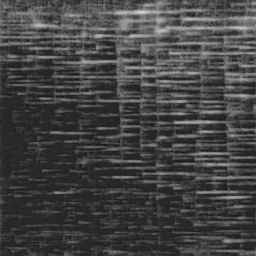

ddim:


  0%|          | 0/50 [00:00<?, ?it/s]

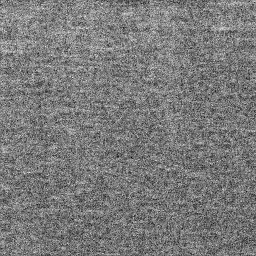

(None, None)

In [ ]:
#@title Load and display comparaisons between trained DDPM and trained DDIM

#@markdown Load the models, generates the samples and display the results for epoch 5, 10 and 15

train_dir = os.path.join(working_dir, repo_name, "trainings","train_DDPMvsDDIM")
os.chdir(train_dir)

print("Loading models...")

print("Loading DDPM models...")
untrained_models_ddpm = [MusicGeneratorModel(model="training_ddpm_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDPM models loaded")

print("Loading DDIM models...")
untrained_models_ddim = [MusicGeneratorModel(model="training_ddim_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDIM models loaded")

print("Epoch 5")
print("ddpm:")
image_ddpm_5, (_, audio_ddpm_5) = untrained_models_ddpm[0].generate_audio()
display(image_ddpm_5), display(Audio(audio_ddpm_5, rate=11025))
print("ddim:")
image_ddim_5, (_, audio_ddim_5) = untrained_models_ddim[0].generate_audio(steps=50)
display(image_ddim_5), display(Audio(audio_ddim_5, rate=11025))

print("Epoch 10")
print("ddpm:")
image_ddpm_10, (_, audio_ddpm_10) = untrained_models_ddpm[1].generate_audio()
display(image_ddpm_10), display(Audio(audio_ddpm_10, rate=11025))
print("ddim:")
image_ddim_10, (_, audio_ddim_10) = untrained_models_ddim[1].generate_audio(steps=50)
display(image_ddim_10), display(Audio(audio_ddim_10, rate=11025))

print("Epoch 15")
print("ddpm:")
image_ddpm_15, (_, audio_ddpm_15) = untrained_models_ddpm[2].generate_audio()
display(image_ddpm_15), display(Audio(audio_ddpm_15, rate=22050))
print("ddim:")
image_ddim_15, (_, audio_ddim_15) = untrained_models_ddim[2].generate_audio()
display(image_ddim_15), display(Audio(audio_ddim_15, rate=22050))


In [ ]:
#@title Generate and save files

out_dir = "DDPM vs DDIM 2" #@param {type:"string"}

train_dir = os.path.join(working_dir, repo_name, "trainings","train_DDPMvsDDIM")
os.chdir(train_dir)

print("Loading models...")

print("Loading DDPM models...")
untrained_models_ddpm = [MusicGeneratorModel(model="training_ddpm_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDPM models loaded")

print("Loading DDIM models...")
untrained_models_ddim = [MusicGeneratorModel(model="training_ddim_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDIM models loaded")

out_path = os.path.join(working_dir, repo_name, "results", out_dir)
os.makedirs(out_path)
os.chdir(out_path)

namep = "{}_ddpm_ep{}_sample{}.{}"
namei = "{}_ddim_ep{}_sample{}.{}"
for ep in range(3):
  for i in range(5):
    image_ddpm, (_, audio_ddpm) = untrained_models_ddpm[ep].generate_audio()
    wav.write(namep.format("audio", str(ep), str(i), "wav"),22050, audio_ddpm)
    image_ddpm.save(namep.format("image", str(ep), str(i), "jpg"))    
    
    image_ddim, (_, audio_ddim) = untrained_models_ddim[ep].generate_audio()
    wav.write(namei.format("audio", str(ep), str(i), "wav"),22050, audio_ddim)
    image_ddim.save(namei.format("image", str(ep), str(i), "jpg"))

#Different losses

We have trained two different DDPM processes with different loss function and here are the results:

In [ ]:
#@title Load and display comparaisons between trained DDPM with different losses

train_dir = os.path.join(working_dir, repo_name, "trainings","train_DDPMvsDDIM")
os.chdir(train_dir)

print("Loading models...")

print("Loading DDPM models...")
untrained_models_ddpm = [MusicGeneratorModel(model="training_ddpm_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDPM models loaded")

print("Loading DDPM models with MSE loss...")
untrained_models_ddim = [MusicGeneratorModel(model="training_ddim_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDPM models with MSE loss loaded")

print("Epoch 5")
print("ddpm:")
image_ddpm_5, (_, audio_ddpm_5) = untrained_models_ddpm[0].generate_audio()
display(image_ddpm_5), display(Audio(audio_ddpm_5, rate=11025))
print("ddim:")
image_ddim_5, (_, audio_ddim_5) = untrained_models_ddim[0].generate_audio()
display(image_ddim_5), display(Audio(audio_ddim_5, rate=11025))

print("Epoch 10")
print("ddpm:")
image_ddpm_10, (_, audio_ddpm_10) = untrained_models_ddpm[1].generate_audio()
display(image_ddpm_10), display(Audio(audio_ddpm_10, rate=11025))
print("ddim:")
image_ddim_10, (_, audio_ddim_10) = untrained_models_ddim[1].generate_audio()
display(image_ddim_10), display(Audio(audio_ddim_10, rate=11025))

print("Epoch 15")
print("ddpm:")
image_ddpm_15, (_, audio_ddpm_15) = untrained_models_ddpm[2].generate_audio()
display(image_ddpm_15), display(Audio(audio_ddpm_15, rate=11025))
print("ddim:")
image_ddim_15, (_, audio_ddim_15) = untrained_models_ddim[2].generate_audio()
display(image_ddim_15), display(Audio(audio_ddim_15, rate=11025))


In [ ]:
#@title Generate and save files DDPM vs DDIM

out_dir = "DDPM vs DDIM 2" #@param {type:"string"}

train_dir = os.path.join(working_dir, repo_name, "trainings","train_DDPM_diffloss")
os.chdir(train_dir)

print("Loading models...")

print("Loading DDPM models...")
untrained_models_ddpm = [MusicGeneratorModel(model="training_ddpm_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDPM models loaded")

print("Loading DDPM models with different losses...")
untrained_models_ddim = [MusicGeneratorModel(model="training_ddpm_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDIM models with different losses loaded")

out_path = os.path.join(working_dir, repo_name, "results", out_dir)
os.makedirs(out_path)
os.chdir(out_path)

namep = "{}_ddpm_ep{}_sample{}.{}"
namei = "{}_ddim_ep{}_sample{}.{}"
for ep in range(3):
  for i in range(5):
    image_ddpm, (_, audio_ddpm) = untrained_models_ddpm[ep].generate_audio()
    wav.write(namep.format("audio", str(ep), str(i), "wav"),22050, audio_ddpm)
    image_ddpm.save(namep.format("image", str(ep), str(i), "jpg"))    
    
    image_ddim, (_, audio_ddim) = untrained_models_ddim[ep].generate_audio()
    wav.write(namei.format("audio", str(ep), str(i), "wav"),22050, audio_ddim)
    image_ddim.save(namei.format("image", str(ep), str(i), "jpg"))

In [ ]:
#@title Generate and save different losses

out_dir = "DDPM L1 vs Huber" #@param {type:"string"}

train_dir1 = os.path.join(working_dir, repo_name, "trainings","train_diff_loss_L1")
train_dir2 = os.path.join(working_dir, repo_name, "trainings","train_diff_loss_huber")

print("Loading models...")

print("Loading DDPM models...")
os.chdir(train_dir1)
untrained_models_ddpm = [MusicGeneratorModel(model="training_ddpm_diffloss_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDPM models loaded")

print("Loading DDPM models with different losses...")
os.chdir(train_dir2)
untrained_models_ddim = [MusicGeneratorModel(model="training_ddpm_diffloss_epoch_{}".format(i)) for i in ["5","10","15"]]
print("DDIM models with different losses loaded")

out_path = os.path.join(working_dir, repo_name, "results", out_dir)
os.makedirs(out_path)
os.chdir(out_path)

namep = "{}_huber_ep15_sample{}.{}"
namei = "{}_l1_ep15_sample{}.{}"
for i in range(5):
    image_ddpm, (_, audio_ddpm) = untrained_models_ddpm[2].generate_audio()
    wav.write(namep.format("audio", str(i), "wav"),22050, audio_ddpm)
    image_ddpm.save(namep.format("image", str(i), "jpg"))    
    
    image_ddim, (_, audio_ddim) = untrained_models_ddim[2].generate_audio()
    wav.write(namei.format("audio",  str(i), "wav"),22050, audio_ddim)
    image_ddim.save(namei.format("image", str(i), "jpg"))

Loading models...
Loading DDPM models...
DDPM models loaded
Loading DDPM models with different losses...
DDIM models with different losses loaded


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#@title Generate and save Best model

out_dir = "trained model_bis" #@param {type:"string"}

train_dir = os.path.join(working_dir,)

print("Loading model...")

print("Loading DDPM model...")
os.chdir(train_dir)
untrained_model_ddpm = MusicGeneratorModel(model="model-30-ep")

out_path = os.path.join(working_dir, repo_name, "results", out_dir)
os.makedirs(out_path)
os.chdir(out_path)

name = "{}_sample{}.{}"
for i in range(10):
    image_ddpm, (_, audio_ddpm) = untrained_model_ddpm.generate_audio()
    wav.write(name.format("audio", str(i), "wav"),22050, audio_ddpm)
    image_ddpm.save(name.format("image", str(i), "jpg"))    


Loading model...
Loading DDPM model...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1672316780.525237cd6ba9.6524.0
	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1672392383.ead8135178b5.1696.0
	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1672399695.ead8135178b5.31233.0
	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1672418898.74c45bf1df1f.1392.0
	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1672647241.1d63f3ece57c.10170.0
	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1672648216.1d63f3ece57c.14252.0
	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1672650798.1d63f3ece57c.24937.0
	deleted:    models/model-30-ep/logs/train_unet/events.out.tfevents.1

In [ ]:
!git pull --no-rebase

remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 4), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://gitlab.ethz.ch/jconan/ddpm-music-generation
   a8e1ead..79e7a12  main       -> origin/main
Performing inexact rename detection: 100% (10557/10557), done.
<s/project_music_diffusion/.git/MERGE_MSG" 7L, 312C▽  [>c]10;?]11;?Merge branch 'main' of https://gitlab.ethz.ch/jconan/ddpm-music-generation into  main

# Please enter a commit message to explain why this merge is necessary,
# especially if it merges an updated upstream into a topic branch.
#
# Lines starting with '#' will be ignored, and an empty message aborts
# the commit.
~                                                                               ~                                                                               ~                                                         

KeyboardInterrupt: ignored

In [19]:
!git pull

On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean


In [20]:
# !git config --global user.email "jconan@student.ethz.ch"
# !git config --global user.name "jconan"
!git add .
!git commit -am "final results"
!git push

On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
Counting objects: 180, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (179/179), done.
Writing objects: 100% (180/180), 3.55 GiB | 8.13 MiB/s, done.
Total 180 (delta 24), reused 0 (delta 0)
remote: Resolving deltas: 100% (24/24), completed with 5 local objects.
remote: 
remote: ========================================================================
remote: 
remote:     February 2023 and with it the next round of user cleanup is just
remote:    around the corner! The gitlab.ethz.ch users without an equivalent
remote:   ETH LDAP-user will be deleted. Together with the users are deleted:
remote:   the users own repositories and the groups where these users are the
remote:   only owner. To avoid losing data, please ensure that the groups you
remote:    use have at least one owner with a valid ETH LDAP-account. 